In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
import scipy.stats as st
sns.set_context('notebook')
plt.style.use('seaborn')
style = {
    'figure.figsize': (12, 8),
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 14,
}
rcParams.update(style)
import pymc3 as pm

In [3]:
data = pd.read_table('OGLE-LMC-DSCT-0001.I.dat', sep='\s+', names=['MJD', 'I', 'dI'])

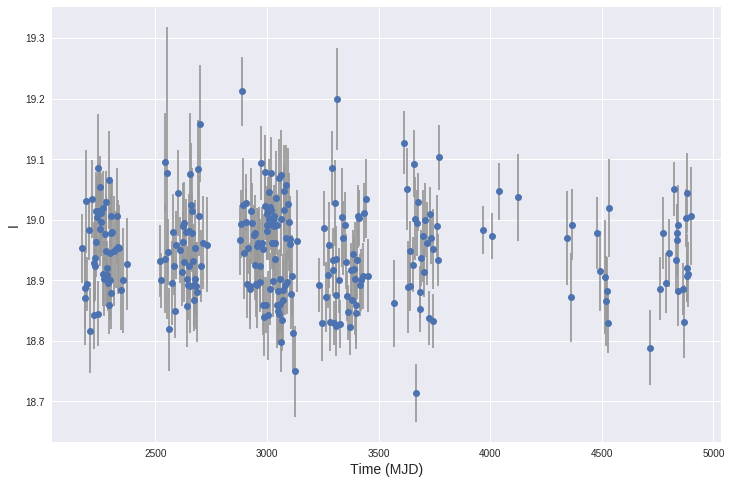

In [4]:
plt.errorbar('MJD', y='I', yerr='dI', data=data, ecolor='.6', fmt='o')
plt.xlabel('Time (MJD)')
plt.ylabel('I')

In [5]:
from astropy.stats import LombScargle
frequency, power = LombScargle(data['MJD'], data['I']).autopower()

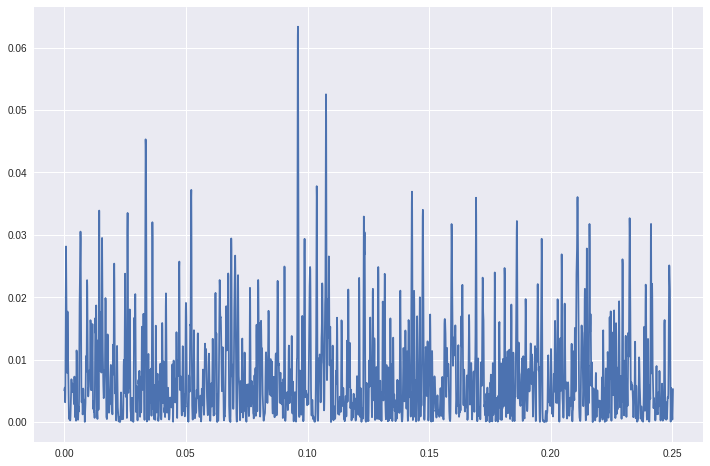

In [6]:
plt.plot(frequency, power)

In [26]:
def sinc(x, A, w, d = 0):
    out = []
    for xi in x:
        if xi == 0:
            out.append(1)
        else:
            out.append(A * np.sin(w * xi - d) / (w * xi - d))
    return np.array(out)

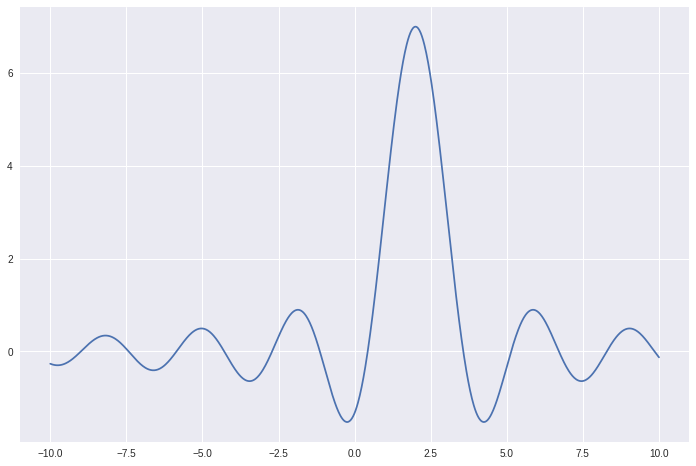

In [35]:
x = np.linspace(-10, 10, 1000)
y = sinc(x, 7, 2, 4)
plt.plot(x, y)

In [64]:
v_nyq = 8
with pm.Model() as model:
    W = pm.Normal('W', mu=0, sd=10)
    R_v = (pm.math.sin( np.pi * frequency / (2 * v_nyq)) / ((np.pi * frequency) / (2 * v_nyq)))**2
    
#     k = pm.DiscreteUniform('k', 0, 5)
    k=3
    a = pm.Normal('a', mu=0, sd=10, shape=(k,1))
    b = pm.Normal('b', mu=0, sd=10, shape=(k,1))
    
    harv = pm.math.sum(2 * pm.math.sqrt(2) / np.pi * (a**2 / b) / (1 + (frequency / b)**4), axis=0)
    
    H0 = pm.Normal('H0', mu=0, sd=10)
    v_max = pm.Bound(pm.Normal, lower=0)('v_max', mu=0, sd=10)
    s = pm.HalfCauchy('s', 10)
    
    e = pm.HalfCauchy('e', 10)
    
    mu = W + R_v * (harv + H0 * pm.math.exp(-(frequency - v_max)**2) / (2 * s**2))
    y = pm.Normal('obs', mu, sd=e, observed=power)

In [65]:
with model:
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [e_log__, s_log__, v_max_lowerbound__, H0, b, a, W]
100%|██████████| 2000/2000 [26:30<00:00,  1.26it/s]
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7095529719285654, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 555 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.

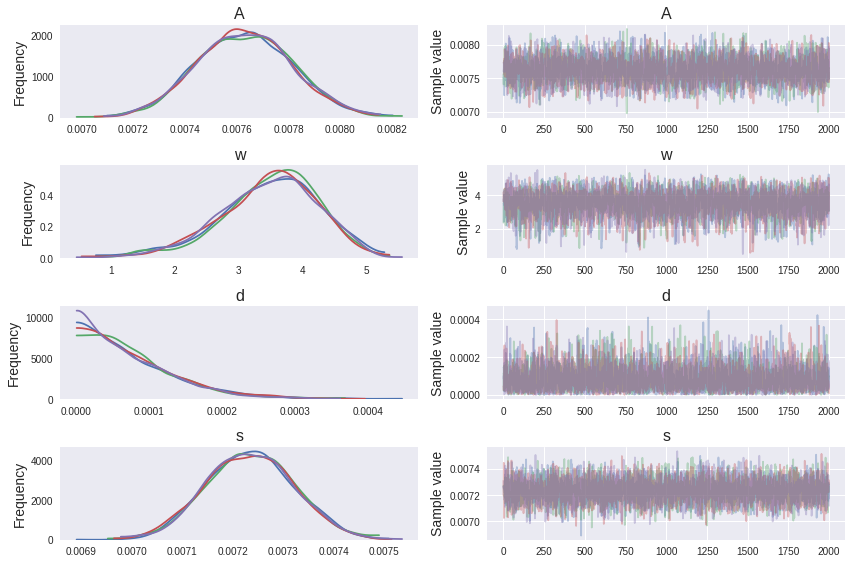

In [55]:
pm.traceplot(trace);

In [56]:
ppc = pm.sample_ppc(trace, 1000, model)
post = ppc['obs'].mean(axis=0)

100%|██████████| 1000/1000 [00:01<00:00, 820.03it/s]


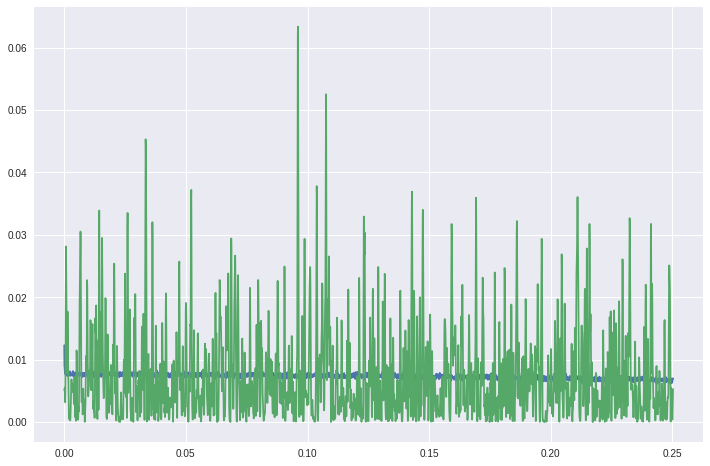

In [58]:
plt.plot(frequency, post)
plt.plot(frequency, power);